# Pre-Requisite
## Loading relevant libraries and input data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data summary
def summary(dtf):
    sumary=pd.concat([dtf.isna().sum(),((dtf == 0).sum())/dtf.shape[0],dtf.dtypes], axis=1)
    sumary=sumary.rename(columns={sumary.columns[0]: 'NaN'})
    sumary=sumary.rename(columns={sumary.columns[1]: 'Zeros'})
    sumary=sumary.rename(columns={sumary.columns[2]: 'Type'})
    sumary['NaN']=sumary['NaN'].astype(str)+' ('+((sumary['NaN']*100/dtf.shape[0]).astype(int)).astype(str)+'%)'
    sumary['Zeros']=(sumary['Zeros']*100).astype(int)
    sumary['Zeros']=(dtf == 0).sum().astype(str)+' ('+sumary['Zeros'].astype(str)+'%)'
    sumary=sumary[['Type','NaN','Zeros']]
    return print(sumary)

In [2]:
df_train = pd.read_csv("/kaggle/input/laptop-price-prediction/laptops_train.csv")
df_test  = pd.read_csv("/kaggle/input/laptop-price-prediction/laptops_test.csv")

# Data Exploration
At a first glance, it is observed that '**Operating System Version**' has zero values (which it should not) and has to be treated further. 

Some columns are formatted as 'Object' when they are supposed to be numerical such as **Screen Size**, **RAM**, **Weight** etc. and they should be treated right away. 

In [3]:
summary(df_train)
df_train.head(5)

                             Type        NaN   Zeros
Manufacturer               object     0 (0%)  0 (0%)
Model Name                 object     0 (0%)  0 (0%)
Category                   object     0 (0%)  0 (0%)
Screen Size                object     0 (0%)  0 (0%)
Screen                     object     0 (0%)  0 (0%)
CPU                        object     0 (0%)  0 (0%)
RAM                        object     0 (0%)  0 (0%)
 Storage                   object     0 (0%)  0 (0%)
GPU                        object     0 (0%)  0 (0%)
Operating System           object     0 (0%)  0 (0%)
Operating System Version   object  136 (13%)  0 (0%)
Weight                     object     0 (0%)  0 (0%)
Price                     float64     0 (0%)  0 (0%)


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


# Data Preprocessing

This step involves removing substrings from supposingly numerical columns and the splitting of columns containing different elements into separate columns as below:

1. **Screen** - split as the following
   * **Screen Resolution** - We split it further into 3 numerical columns (Width, Height & Area) eg. for 1920x1080, Width=1920, Height=1080, Area=1920*1080=2073600, we then remove "Height" column as 'Weight' and 'Area' is enough to provide all 3 informations.
     
   * **Screen feature** (eg. IPS Display, Touchscreen, Retina Display) - We assign one binary column for each Screen Feature to indicate if the laptop has such screen feature.
   
2. **Storage** - Splitted into 4 columns indicating volume of each storage type (HDD, SSD, Flash Storage & Hybrid) , each 1TB is converted into 1000GB
   
3. **CPU** - We extract only the processor speed in GHz and rename it as "CPU_Speed"





In [4]:
df=pd.concat([df_train,df_test])

# Splitting "Screen" column
df['Screen Size']=df['Screen Size'].str.replace('"', '').astype(float)
df['Resolution_1']=df['Screen'].str.rsplit('x', n=1).str[0].str[-4:].astype(int)
df['Resolution_2']=df['Screen'].str.rsplit('x', n=1).str[1].str[-4:].astype(int)
df['Resolution_total']=df['Resolution_1']*df['Resolution_2']
df['IPS Panel'] = (df['Screen'].str.contains('IPS Panel')).astype(int)
df['Touchscreen'] = (df['Screen'].str.contains('Touchscreen')).astype(int)
df['Retina Display'] = (df['Screen'].str.contains('Retina Display')).astype(int)

# Extracting CPU_Speed from "CPU"
df['CPU_Speed']=df['CPU'].str.rsplit(n=1).str.get(-1).str.replace('GHz', '').astype(float)
df['CPU'] = df['CPU'].str.rsplit(n=1).str[0]

# Splitting "Storage" into HDD, SSD, Flash Storage & hybrid storage volumes in GB
df['SSD']=df[' Storage'].str.extract(r'\b(\w+)\s+SSD\b')
df['HDD']=df[' Storage'].str.extract(r'\b(\w+)\s+HDD\b')
df['Flash_Storage']=df[' Storage'].str.extract(r'\b(\w+)\s+Flash\sStorage\b')
df['Hybrid']=df[' Storage'].str.extract(r'\b(\w+)\s+Hybrid\b')
df['HDD']=df['HDD'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)
df['SSD']=df['SSD'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)
df['Flash_Storage']=df['Flash_Storage'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)
df['Hybrid']=df['Hybrid'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)

# Combine Operating System and its version
df['OS'] = df['Operating System'] + ' ' + df['Operating System Version'].fillna(' ')

# Other misc. cleansing steps
df['RAM']=df['RAM'].str.replace('GB', '').astype(int)
df['Weight']=df['Weight'].str.replace('kgs', '').str.replace('kg', '').astype(float)

summary(df)
df.head(5)


                             Type        NaN       Zeros
Manufacturer               object     0 (0%)      0 (0%)
Model Name                 object     0 (0%)      0 (0%)
Category                   object     0 (0%)      0 (0%)
Screen Size               float64     0 (0%)      0 (0%)
Screen                     object     0 (0%)      0 (0%)
CPU                        object     0 (0%)      0 (0%)
RAM                         int64     0 (0%)      0 (0%)
 Storage                   object     0 (0%)      0 (0%)
GPU                        object     0 (0%)      0 (0%)
Operating System           object     0 (0%)      0 (0%)
Operating System Version   object  170 (13%)      0 (0%)
Weight                    float64     0 (0%)      0 (0%)
Price                     float64     0 (0%)      0 (0%)
Resolution_1                int64     0 (0%)      0 (0%)
Resolution_2                int64     0 (0%)      0 (0%)
Resolution_total            int64     0 (0%)      0 (0%)
IPS Panel                   int

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,...,Resolution_total,IPS Panel,Touchscreen,Retina Display,CPU_Speed,SSD,HDD,Flash_Storage,Hybrid,OS
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,...,4096000,1,0,1,2.3,128,0,0,0,macOS
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,...,1296000,0,0,0,1.8,0,0,128,0,macOS
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U,8,256GB SSD,Intel HD Graphics 620,No OS,...,2073600,0,0,0,2.5,256,0,0,0,No OS
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7,16,512GB SSD,AMD Radeon Pro 455,macOS,...,5184000,1,0,1,2.7,512,0,0,0,macOS
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,...,4096000,1,0,1,3.1,256,0,0,0,macOS


# EDA

**Price Breakdown by Brand:**

By observing the price distribution of different laptop brands, we can divide the brands into at least 4 different price tiers according to their price range and median price:
* Tier 1   : Vero, Mediacom, Chuwi
* Tier 1.5 : Acer, Fujitsu
* Tier 2   : HP, Dell, Lenovo, Asus, Xiaomi
* Tier 2.5 : Toshiba
* Tier 3   : Huawei, Apple, Microsoft, MSI, Samsung , Google
* Tier 3.5 : LG
* Tier 4   : Razer

<AxesSubplot:xlabel='Price', ylabel='Manufacturer'>

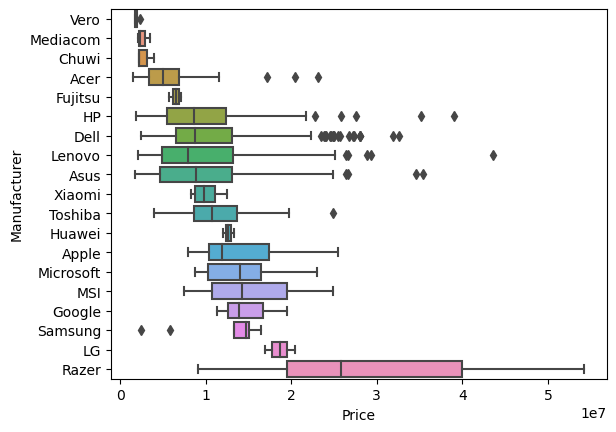

In [5]:
sns.boxplot(x=df['Price'], y=df['Manufacturer'],orient='h', order=["Vero","Mediacom","Chuwi","Acer","Fujitsu","HP","Dell","Lenovo","Asus","Xiaomi","Toshiba","Huawei","Apple","Microsoft","MSI","Google","Samsung","LG","Razer"])
#plt.boxplot(data, notch=None, vert=None, patch_artist=None, widths=None)

**Price Breakdown by Laptop Category**

The price difference is obvious between categories, it is observed that *Netbooks* are the cheapest, this is followed by *Notebook* and eventually the costliest laptops are from the *Workstation* Category. 

Besides, the price distribution *Ultrabook* is fairly close to *2 in 1 Convertible* and *Gaming Laptops* are fairly close in terms of either price range or median price.

<AxesSubplot:xlabel='Price', ylabel='Category'>

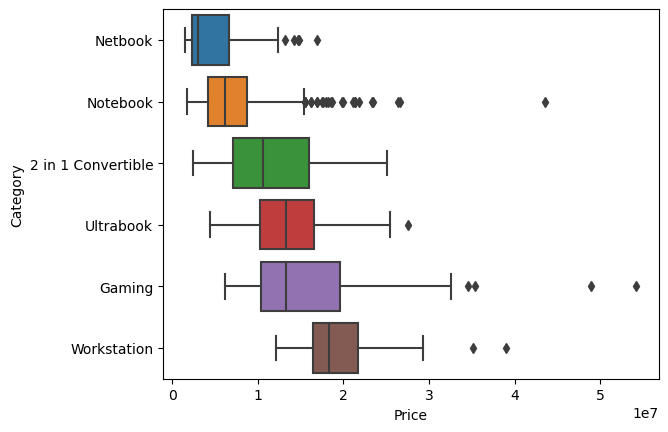

In [6]:
sns.boxplot(x=df['Price'], y=df['Category'],orient='h', order=["Netbook","Notebook","2 in 1 Convertible","Ultrabook","Gaming","Workstation"])

**Price Breakdown by Operating System Version**



<AxesSubplot:xlabel='Price', ylabel='OS'>

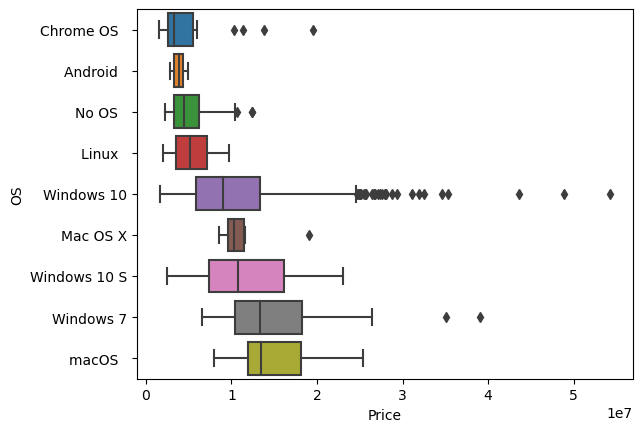

In [7]:
sns.boxplot(x=df['Price'], y=df['OS'],orient='h', order=["Chrome OS  ","Android  ","No OS  ","Linux  ","Windows 10","Mac OS X","Windows 10 S","Windows 7","macOS  "])

**Qualitative Variable EDA (Correlation)**

We analyse the relationship between numerical variables and the price using a correlation heatmap. Some findings from the correlation matrix are:

1. **Resolution_1**, **Resolution_2** and **Resolution_total** are all positively correlated, we will only keep 1 of the Resolution variable and eliminate the other 2. In this case we keep only **Resolution_1** because it has the highest positive correlation with Price compared to the other 2.
2. **Screen Size** and **Weight** are highly correlated (r=0.8) and we will keep the only one which has a greater relationship with **Price**, in this case it would be **Weight** (r=0.2).
3. Price is highly positively correlated with **RAM** (r=0.7), **Resolution** (r=0.6) and **SSD** (r=0.7), so we would expect to see laptops with more RAM, higher resolution and greater SSD storage space to be costlier.
4. The **Flash_Storage** and **Hybrid** storage columns have little to no relationship (r=0) with the Price and therefore will be removed from the model.



<AxesSubplot:>

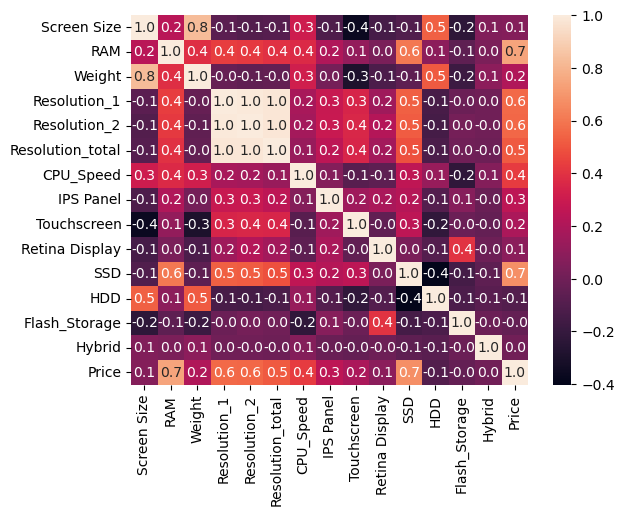

In [8]:
sns.heatmap(df[['Screen Size','RAM','Weight','Resolution_1','Resolution_2','Resolution_total','CPU_Speed','IPS Panel','Touchscreen','Retina Display','SSD','HDD','Flash_Storage','Hybrid','Price']].corr(), annot=True, fmt=".1f")

Correlation Matrix after removing the relevant columns as below:

<AxesSubplot:>

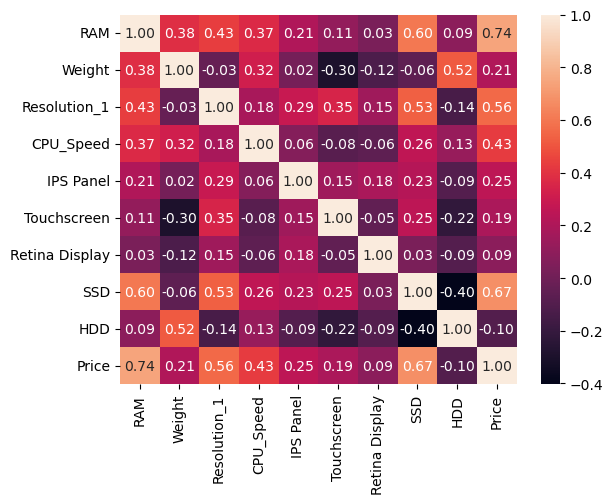

In [9]:
df=df.drop(['Resolution_2','Resolution_total','Screen Size','Flash_Storage','Hybrid'], axis=1)
sns.heatmap(df[['RAM','Weight','Resolution_1','CPU_Speed','IPS Panel','Touchscreen','Retina Display','SSD','HDD','Price']].corr(), annot=True, fmt=".2f")

# Data Transformation

Distribution of Weight is observed to be positively skewed. By taking a log-transformation approach, we manage to normalize it despite having a few stubborn outliers.

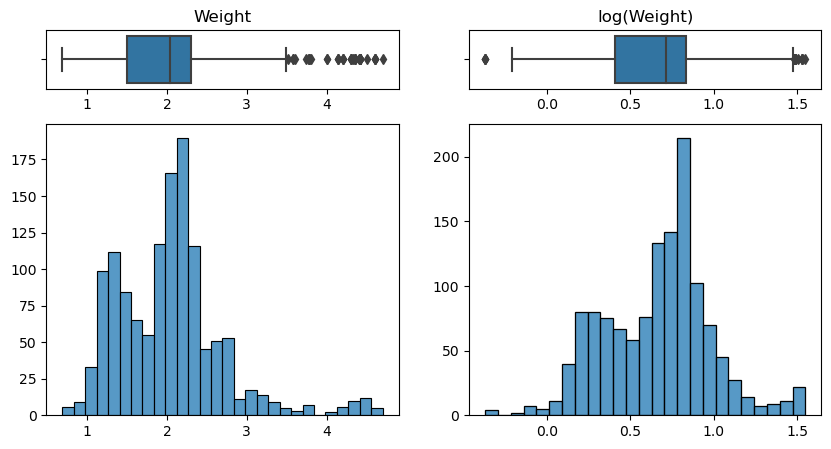

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 5]})
sns.boxplot(x=df['Weight'], orient='h', ax=axs[0, 0])
axs[0, 0].set_xlabel('')
axs[0, 0].set_title('Weight')
sns.histplot(x=df['Weight'], ax=axs[1, 0])
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')
sns.boxplot(x=np.log(df['Weight']), orient='h', ax=axs[0, 1])
axs[0, 1].set_xlabel('')
axs[0, 1].set_title('log(Weight)')
sns.histplot(x=np.log(df['Weight']), ax=axs[1, 1])
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('')
plt.show()

We do the same for 'HDD' and 'SSD' which are also positively-skewed.

In [11]:
# Log-transforming Positively-skewed fields: Weight, HDD & SSD
df['Weight']=np.log(df['Weight'])
df['HDD']=np.log(df['HDD'].replace(0, np.nan)).fillna(0)
df['SSD']=np.log(df['SSD'].replace(0, np.nan)).fillna(0)

# Capping of Outliers in 'Screen Size'
# percentiles = df1['Screen Size'].quantile([0.05, 0.95]).values
# df1['Screen Size']=np.clip(df1['Screen Size'], percentiles[0], percentiles[1])

# Feature Engineering
We will now perform One-Hot Encoding on the string columns 'Manufacturer', 'Category' and 'OS' to assign a binary indicator column for each unique value, and keep only n-1 of those values.

Example: 
We remove the 'Manufacturer_Chuwi' column because a '0' in all other *Manufacturer* columns will automatically indicate that the laptop's Manufacturer is Chuwi.

We will do the same for 'Category' and 'OS' columns and apply the same logic:
* 'Category' - Removed 'Category_2 in 1 Convertible'
* 'OS'       - Removed 'OS_No OS'


In [12]:
#Version 1 - one hot encode
df = pd.get_dummies(df, columns = ['Manufacturer','Category','OS'])
df.drop(['Category_2 in 1 Convertible','Manufacturer_Chuwi','OS_No OS  '],axis=1, inplace=True)

#Version 2 - just remove
#df.drop(['Manufacturer','Category','OS'], axis=1, inplace=True)

#Version 3 - assign custom rank
#f['Manufacturer']=df['Manufacturer'].replace(['Apple','Huawei','Microsoft','MSI','Samsung','Google'],'3').replace(['Vero','Mediacom','Chuwi'],'1').replace(['Acer','Fujitsu'],'1.5').replace(['HP','Dell','Lenovo','Asus','Xiaomi'],'2').replace(['Toshiba'],'2.5').replace(['LG'],'3.5').replace(['Razer'],'4').astype(float)
#f['Category']=df['Category'].replace({ 'Netbook' : 1, 'Notebook' : 2, '2 in 1 Convertible' : 3, 'Ultrabook' : 3.5, 'Gaming' : 4, 'Workstation' : 5 })
#f = pd.get_dummies(df, columns = ['OS'])
#f.drop(['OS_No OS  '],axis=1, inplace=True)


df.drop(['Model Name','Screen',' Storage','GPU','CPU','Operating System','Operating System Version'],axis=1, inplace=True)
summary(df)
df.head(5)


                           Type     NaN       Zeros
RAM                       int64  0 (0%)      0 (0%)
Weight                  float64  0 (0%)      0 (0%)
Price                   float64  0 (0%)      0 (0%)
Resolution_1              int64  0 (0%)      0 (0%)
IPS Panel                 int64  0 (0%)   937 (71%)
Touchscreen               int64  0 (0%)  1111 (85%)
Retina Display            int64  0 (0%)  1285 (98%)
CPU_Speed               float64  0 (0%)      0 (0%)
SSD                     float64  0 (0%)   465 (35%)
HDD                     float64  0 (0%)   727 (55%)
Manufacturer_Acer         uint8  0 (0%)  1199 (92%)
Manufacturer_Apple        uint8  0 (0%)  1281 (98%)
Manufacturer_Asus         uint8  0 (0%)  1145 (87%)
Manufacturer_Dell         uint8  0 (0%)  1005 (77%)
Manufacturer_Fujitsu      uint8  0 (0%)  1299 (99%)
Manufacturer_Google       uint8  0 (0%)  1299 (99%)
Manufacturer_HP           uint8  0 (0%)  1028 (78%)
Manufacturer_Huawei       uint8  0 (0%)  1300 (99%)
Manufacturer

,RAM,Weight,Price,Resolution_1,IPS Panel,Touchscreen,Retina Display,CPU_Speed,SSD,HDD,...,Category_Ultrabook,Category_Workstation,OS_Android,OS_Chrome OS,OS_Linux,OS_Mac OS X,OS_Windows 10,OS_Windows 10 S,OS_Windows 7,OS_macOS
0,8,0.314811,11912523.48,2560,1,0,1,2.3,4.852030,0.0,...,1,0,0,0,0,0,0,0,0,1
1,8,0.292670,7993374.48,1440,0,0,0,1.8,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,1
2,8,0.620576,5112900.00,1920,0,0,0,2.5,5.545177,0.0,...,0,0,0,0,0,0,0,0,0,0
3,16,0.604316,22563005.40,2880,1,0,1,2.7,6.238325,0.0,...,1,0,0,0,0,0,0,0,0,1
4,8,0.314811,16037611.20,2560,1,0,1,3.1,5.545177,0.0,...,1,0,0,0,0,0,0,0,0,1


# Data Scaling

We will now scale the numerical non-binary columns using MinMax Scaler to ensure all values fall within the same range.

In [13]:
from sklearn.preprocessing import MinMaxScaler
numeric_col=['RAM','Weight','Resolution_1','CPU_Speed','SSD','HDD']
df[numeric_col] = MinMaxScaler().fit_transform(df[numeric_col])
df.head(5)

,RAM,Weight,Price,Resolution_1,IPS Panel,Touchscreen,Retina Display,CPU_Speed,SSD,HDD,...,Category_Ultrabook,Category_Workstation,OS_Android,OS_Chrome OS,OS_Linux,OS_Mac OS X,OS_Windows 10,OS_Windows 10 S,OS_Windows 7,OS_macOS
0,0.096774,0.357482,11912523.48,0.482619,1,0,1,0.518519,0.702403,0.0,...,1,0,0,0,0,0,0,0,0,1
1,0.096774,0.345942,7993374.48,0.029911,0,0,0,0.333333,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,1
2,0.096774,0.516849,5112900.00,0.223929,0,0,0,0.592593,0.802747,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.225806,0.508374,22563005.40,0.611964,1,0,1,0.666667,0.903090,0.0,...,1,0,0,0,0,0,0,0,0,1
4,0.096774,0.357482,16037611.20,0.482619,1,0,1,0.814815,0.802747,0.0,...,1,0,0,0,0,0,0,0,0,1


# Test-Train Split
With the dataset ready to be trained, we proceed to split the test and train data which were combined earlier for data cleansing. The algorithms will have their hyperparameters tuned using Optuna.

We will try to fit this regression problem using the following algorithms and evaluate their performance based on R-squared, MAE and RMSE values:
*  Linear Regression
*  Linear SVR
* Lasso
* ElasticNet
* Ridge
* Decision Tree
* Random Forest
* Gradient Boost
* XGBoost

In [14]:
import optuna
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

y_train=df['Price'].iloc[0:len(df_train)]
x_train=df.drop(['Price'],axis=1).iloc[0:len(df_train)]
y_test=df['Price'].iloc[len(df_train):]
x_test=df.drop(['Price'],axis=1).iloc[len(df_train):]

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [15]:
def objective(trial):
    #loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    #criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])
    #n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    #min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    #max_features = trial.suggest_categorical('max_features', ['auto','sqrt','log2'])
    model = GradientBoostingRegressor(loss='squared_error', criterion='squared_error', max_depth=max_depth, min_samples_split=8, min_samples_leaf=min_samples_leaf, max_features='sqrt')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params


{'max_depth': 10, 'min_samples_leaf': 4}

In [16]:
def objective(trial):
    #criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse','absolute_error', 'poisson'])
    #splitter = trial.suggest_categorical('splitter', ['best','random'])
    #max_depth = trial.suggest_int('max_depth', 5, 10)
    #min_samples_split = trial.suggest_int('min_samples_split', 20, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 30)
    #max_features = trial.suggest_categorical('max_features', ['auto','sqrt','log2'])
    model = DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=10, min_samples_split=28, min_samples_leaf=2, max_features='auto')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params



{}

In [17]:
def objective(trial):
    #criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse','absolute_error', 'poisson'])
    max_depth = trial.suggest_int('max_depth', 8, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5)
    #max_features = trial.suggest_categorical('max_features', ['auto','sqrt','log2'])
    model = RandomForestRegressor(criterion='friedman_mse', max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=2, max_features='auto')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params


{'max_depth': 15, 'min_samples_split': 11}

In [18]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01,1)
    tol=trial.suggest_float('tol',0.15, 0.6)
    fit_intercept = trial.suggest_categorical('fit_intercept', ['True', 'False'])
    max_iter = trial.suggest_int('max_iter',10,50)
    warm_start=trial.suggest_categorical('warm_start',['True','False'])
    #positive=trial.suggest_categorical('positive',['True','False'])
    #selection=trial.suggest_categorical('selection',['cyclic','random'])
    model = Lasso(tol=tol, alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter, positive=False, warm_start=warm_start, selection='cyclic')

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

{'alpha': 0.9997139788035094,
 'tol': 0.16199880190932456,
 'fit_intercept': 'True',
 'max_iter': 41,
 'warm_start': 'True'}

In [19]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.002,0.003)
    tol=trial.suggest_float('tol',0.18, 0.19)
    l1_ratio=trial.suggest_float('l1_ratio',0.04, 1.5)
    fit_intercept = trial.suggest_categorical('fit_intercept', ['True', 'False'])
    max_iter = trial.suggest_int('max_iter',5,100)
    warm_start=trial.suggest_categorical('warm_start',['True','False'])
    positive=trial.suggest_categorical('positive',['True','False'])
    selection=trial.suggest_categorical('selection',['cyclic','random'])
    model = ElasticNet(tol=tol, alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter, positive=positive, warm_start=warm_start, selection=selection)

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

{'alpha': 0.002239257652868306,
 'tol': 0.1828160282159671,
 'l1_ratio': 1.0833803174085201,
 'fit_intercept': 'True',
 'max_iter': 43,
 'warm_start': 'False',
 'positive': 'False',
 'selection': 'random'}

In [20]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001,1)
    fit_intercept = trial.suggest_categorical('fit_intercept', ['True', 'False'])
    #solver=trial.suggest_categorical('solver',['auto','svd','cholesky','lsqr','sparse_cg','sag','saga'])
    #model = Ridge(alpha=alpha, fit_intercept=fit_intercept, solver=solver, positive=False)
    #solver=trial.suggest_categorical('solver',['auto','lbfgs'])
    model = Ridge(alpha=alpha, fit_intercept=fit_intercept, solver='lbfgs', positive=True)

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

{'alpha': 0.4654058133642768, 'fit_intercept': 'True'}

In [21]:
def objective(trial):
    #loss=trial.suggest_categorical('loss',['epsilon_insensitive','squared_epsilon_insensitive'])
    tol=trial.suggest_float('tol',0.06,0.5)
    C=trial.suggest_float('C',0.001,1)
    epsilon=trial.suggest_float('epsilon',0.001,0.1)
    #fit_intercept=trial.suggest_categorical('fit_intercept',['True','False'])
    intercept_scaling=trial.suggest_float('intercept_scaling',0.001,2)
    max_iter=trial.suggest_int('max_iter',10,200)
    model = LinearSVR(loss='squared_epsilon_insensitive', tol=tol, C=C, epsilon=epsilon, fit_intercept=False, intercept_scaling=intercept_scaling, max_iter=max_iter)

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


{'tol': 0.12094531494303987,
 'C': 0.8834152654052335,
 'epsilon': 0.05446723712613074,
 'intercept_scaling': 1.1632959882274059,
 'max_iter': 76}

In [22]:
def objective(trial):
    eta = trial.suggest_float('eta', 0.24,0.28)
    #min_child_weights = trial.suggest_float('min_child_weights', 0.5, 1)
    #max_depth = trial.suggest_int('max_depth', 3, 5)
    gamma=trial.suggest_float('gamma',0.7,1)
    #subsample = trial.suggest_float('subsample', 0.8,1)
    model = XGBRegressor(eta=eta, max_depth=3, gamma=gamma, subsample=0.99)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

{'eta': 0.25940691252805, 'gamma': 0.7203868765894162}

In [23]:
SVR = LinearSVR(tol=0.19464901232627588, intercept_scaling=0.39959576178102174, C=0.7942999942357071, epsilon=0.0914737309086926, loss='squared_epsilon_insensitive', fit_intercept=False, max_iter=36)
SVR.fit(x_train, y_train)
y_pred = SVR.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.7199
Mean Absolute Error:  2,307,395.09
Root Mean Squared Error:  3,140,389.59


In [24]:
LR = LinearRegression()
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.7095
Mean Absolute Error:  2,321,944.94
Root Mean Squared Error:  3,198,147.15


In [25]:
LS = Lasso(alpha=0.9729, tol=0.21, fit_intercept=True, max_iter=32, warm_start=False, positive=True, selection='random')
LS.fit(x_train, y_train)
y_pred = LS.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.6985
Mean Absolute Error:  2,380,029.26
Root Mean Squared Error:  3,258,435.01


In [26]:
EN = ElasticNet(l1_ratio=0.28645777, alpha=0.0021715385, tol=0.1809, fit_intercept=True, max_iter=42, warm_start=True, positive=True, selection='random')
EN.fit(x_train, y_train)
y_pred = EN.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.6983
Mean Absolute Error:  2,390,714.25
Root Mean Squared Error:  3,259,157.29


In [27]:
RD = Ridge(alpha=0.4653746, solver='lbfgs', fit_intercept=False, positive=True)
RD.fit(x_train, y_train)
y_pred = RD.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.7154
Mean Absolute Error:  2,259,599.41
Root Mean Squared Error:  3,165,877.68


In [28]:
DT = DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=10, min_samples_split=28, min_samples_leaf=2, max_features='auto')
DT.fit(x_train, y_train)
y_pred = DT.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.7325
Mean Absolute Error:  2,088,034.77
Root Mean Squared Error:  3,069,377.84


In [29]:
RF = RandomForestRegressor(criterion='friedman_mse', max_depth=13, min_samples_split=13, min_samples_leaf=2, max_features='auto')
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.7431
Mean Absolute Error:  2,011,300.19
Root Mean Squared Error:  3,007,832.63


In [30]:
GB = GradientBoostingRegressor(loss='squared_error', criterion= 'squared_error', max_features= 'sqrt', max_depth=8, min_samples_split=5, min_samples_leaf=3)
GB.fit(x_train, y_train)
y_pred = GB.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.7914
Mean Absolute Error:  1,774,075.22
Root Mean Squared Error:  2,710,194.20


In [31]:
XG = XGBRegressor(eta=0.22194817, max_depth=3, gamma=0.881835, subsample=0.833423)
#XG = XGBRegressor(eta=0.15530849245464934, max_depth=3, gamma=0.7421963441059264, subsample=0.8100368086395764)
XG.fit(x_train, y_train)
y_pred = XG.predict(x_test)
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared:  0.8230
Mean Absolute Error:  1,714,265.38
Root Mean Squared Error:  2,496,452.52
